### Intro

In [ ]:
from __future__ import unicode_literals, print_function, absolute_import, division
try:
    from future_builtins import ascii, hex, filter, map, oct, zip
except ImportError:
    pass

In [22]:
%reset  -sf
# -sf  # (s for soft, f for forced without approval)
%matplotlib inline

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import os.path

In [24]:
import sys
sys.path.append('/Volumes/Python/pyCalliphony')
from savitzki_golay import savitzky_golay

### Constants

In [46]:
HEADERS = ('cpu_time', 'sample_pos', 'f0')
FRAME_DUR = 0.005/48000*44100
FS = 48000
frame_points = int(round(FRAME_DUR*FS))

##### Paths  `# << FILE NAME TO UPDATE! >>`

In [47]:
FNAME = 'limsi_fr_tat_0006_perf_00.txt'  # << FNAME TO UPDATE! >>
PATH = '/Users/mev/Desktop/__IS2015__/__IS2015__/DATA/STIMULI_OP/colere_tst44k'
FPATH = os.path.join(PATH, FNAME)
if os.path.isfile(FPATH):
    print('OK:', FNAME, 'is well there.')
else:
    raise ValueError("File {} is not present in the given path!".format(FPATH))

OK: limsi_fr_tat_0006_perf_00.txt is well there.


### Main

Reshape according to the headers num and all row (-1)

In [48]:
coord_arr = np.genfromtxt(FPATH).reshape(-1, len(HEADERS))
coord_df = pd.DataFrame(coord_arr, columns=HEADERS)
coord_df.insert(1, 'position', coord_df['sample_pos'] / FS)
coord_df[:5]

,cpu_time,position,sample_pos,f0
0,27013.365234,0.005,240,272.167297
1,27017.759766,0.010,480,272.167297
2,27021.970703,0.015,720,272.265778
3,27027.189453,0.020,960,272.265778
4,27031.259766,0.025,1200,272.476959


In [49]:
coord_df[-5:]

,cpu_time,position,sample_pos,f0
986,31277.333984,3.496229,167819,278.917542
987,31277.365234,3.501229,168059,278.917542
988,31286.201172,3.506229,168299,280.218018
989,31286.236328,3.511229,168539,280.218018
990,31290.417969,3.516229,168779,281.480896


Include the original f0 file: to get the number of samples and to get the VUV param

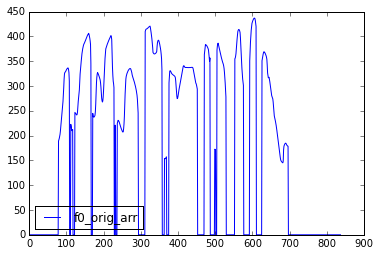

In [50]:
main_path, coord_fname = os.path.split(FPATH)
f0_fpath = os.path.join(main_path, '_'.join(coord_fname.split('_')[:4]) + '.f0')
# noinspection PyNoneFunctionAssignment
f0_orig_arr = np.fromfile(f0_fpath, dtype='f4')
f0_uv_idx = np.where(f0_orig_arr == 0)[0]  # Unvoiced indexes

# print('f0_uv_idx:', f0_uv_idx)
plt.plot(f0_orig_arr)
plt.legend(['f0_orig_arr'], loc='best');

Extract relative time from CPU time

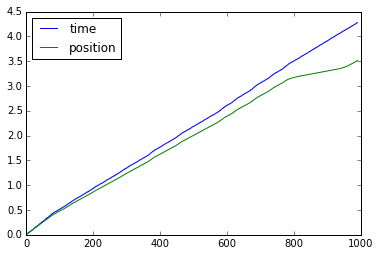

In [51]:
coord_time = coord_df['cpu_time'] - coord_df.iloc[0]['cpu_time']
coord_df.insert(1, 'time', coord_time/1000)  # Insert in df after cpu_time column (and express in s (from ms))

plt.plot(coord_df['time'])
plt.plot(coord_df['position'])
plt.legend(['time', 'position'], loc='best');

Smooth time and f0 curves

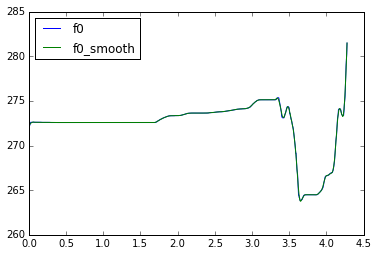

In [52]:
coord_df['time_smooth'] = savitzky_golay(np.array(coord_df['time']), window_size=21, order=2)
coord_df['pos_smooth'] = savitzky_golay(np.array(coord_df['position']), window_size=21, order=2)
coord_df['f0_smooth'] = savitzky_golay(np.array(coord_df['f0']), window_size=21, order=2)

# plt.plot(coord_df['time'], coord_df['position'], coord_df['time_smooth'], coord_df['pos_smooth'])
# plt.legend(['position', 'position_smooth'], loc='best')
plt.plot(coord_df['time'], coord_df['f0'], coord_df['time_smooth'], coord_df['f0_smooth'])
plt.legend(['f0', 'f0_smooth'], loc='best');

Warp f0 values to the original wav file time (from STRAIGHT)

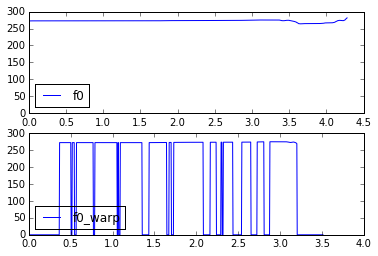

In [53]:
posit_max = round(coord_df['pos_smooth'].iloc[-1] * 2, 2)/2   # round values to 0.005 (0.01/2)
posit = np.arange(start=FRAME_DUR, stop=posit_max, step=FRAME_DUR)   # TODO 0 > FRAME_LEN, better solution?
tck = interpolate.splrep(coord_df['pos_smooth'], coord_df['f0_smooth'], s=5)    # , s=10)
f0_warp = interpolate.splev(posit, tck, der=0)

    # Set zeros to unvoiced sections
f0_uv_idx = [el for el in f0_uv_idx if el < len(f0_warp)]
f0_warp[f0_uv_idx] = 0

f1, ax_arr = plt.subplots(2, sharey=True)
ax_arr[0].plot(coord_df['time'], coord_df['f0'])
ax_arr[0].legend(['f0'], loc='best')
ax_arr[1].plot(posit, f0_warp)
ax_arr[1].legend(['f0_warp'], loc='best');
# plt.plot(coord_df['time'], coord_df['f0'], posit, f0_warp)
# plt.legend(['f0', 'f0_warp'], loc='best')

##### Interpolate the time array to a STRAIGHT time mapping format (`imap = 1 : 1/(frame_points) : num_frames;`)

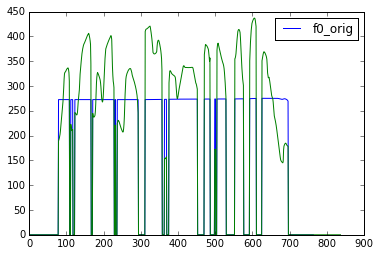

In [54]:
plt.plot(f0_warp)
plt.legend(['f0_warp'], loc='best')
plt.plot(f0_orig_arr)
plt.legend(['f0_orig'], loc='best')
plt.show();
# print(len(f0_warp), len(f0_orig_arr))

In [55]:
num_frames = len(f0_orig_arr)
time_max = coord_df['time_smooth'].max()
pos_max = coord_df['pos_smooth'].max()

print('num_frames:', num_frames, '\t', 'time_max:', time_max, '\t', 'pos_max:', pos_max)

num_frames: 838 	 time_max: 4.277052735 	 pos_max: 3.51622916667


Set the number of elements in the imap vector according to the total length of the target duration wav

In [56]:
# imap_idx = np.arange(start=1, stop=num_frames, step=1/frame_points)
# num_imap_idxs = int(num_frames*frame_points*(time_max/pos_max))

In [57]:
target_frame_points_avg = round(frame_points * (time_max/pos_max))

print('global time ratio:', time_max/pos_max)
print('target_frame_points_avg:', target_frame_points_avg)

global time ratio: 1.2163748528
target_frame_points_avg: 268.0


In [58]:
frame_points * time_max/pos_max

267.60246761504675

In [59]:
# imap_idx = np.arange(start=1, stop=num_imap_idxs+1)

In [60]:
imap_idx = np.arange(start=1, stop=num_frames, step=1/target_frame_points_avg)
# imap_time = imap_idx / num_frames * pos_max / 1.000001    # FIXME: eps val > avoid rounding problem in interpol

print('imap_idx:', imap_idx)

imap_idx: [   1.            1.00373134    1.00746269 ...,  837.98880597  837.99253731
  837.99626866]


Apply the interpollation to the imap vector

* TRY: using simple interpollations from `pos_t` to `cpu_t`

In [61]:
# time_interp_fct = interpolate.interp1d(coord_df['pos_smooth'], coord_df['time_smooth'], 'linear')
# time_map = time_interp_fct(imap_time)
# print('time_map:', time_map)
# imap_int = time_map * num_frames / time_max                       # normalize max value to total number of frames

* TRY: using simple interpollations `cpu_t` to `pos_t`

imap_time: [ 0.00510388  0.00512293  0.00514197 ...,  4.2769956   4.27701465
  4.27703369]
time_map: [ 0.01019425  0.01021382  0.0102334  ...,  3.51616292  3.516185    3.51620708]
imap: [   2.42952915    2.43419422    2.43885928 ...,  837.98421176  837.98947451
  837.99473725]


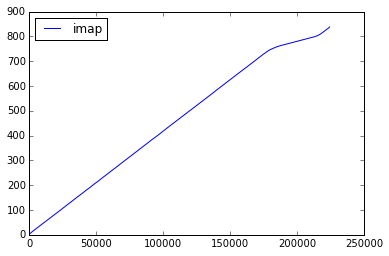

In [62]:
imap_time = imap_idx / num_frames * time_max
print('imap_time:', imap_time)

# time_interp_fct = interpolate.interp1d(coord_df['time_smooth'], coord_df['pos_smooth'], 'linear')
# time_map = time_interp_fct(imap_time)
time_map = np.interp(x=imap_time, xp=coord_df['time_smooth'], fp=coord_df['pos_smooth'])
print('time_map:', time_map)

imap = time_map * num_frames / pos_max                       # normalize max value to total number of frames
print('imap:', imap)

plt.plot(imap)
plt.legend(['imap'], loc='best')

* TRY: using differentials

In [63]:
# imap_time = imap_idx / num_frames * pos_max
# imap_idx_diff = np.diff(imap_time)
# pos_diff = np.diff(coord_df['pos_smooth'])
# time_diff = np.diff(coord_df['time_smooth'])
# local_ratio = np.divide(time_diff, pos_diff)
# local_ratio_smooth = savitzky_golay(local_ratio, window_size=51, order=3)

# plt.plot(coord_df['pos_smooth'].values[:-1], time_diff)
# plt.legend(['time_diff'], loc='best')

# time_map_diff = np.interp(x=imap_time, xp=coord_df['pos_smooth'].values[1:], fp=local_ratio_smooth)
# target_frame_points_arr = time_map_diff*frame_points
# imap_diff = np.divide(1, target_frame_points_arr)
# imap = np.cumsum(imap_diff)  # FIXME**: integral need a multiplication (cumsum())
# imap = imap / imap.max() * num_frames + 1   # FIXME: correct max value, this should be fine without correction!?

##### Interpol f0 values to the final wav file time (from STRAIGHT) `# DEBUG TEST!!**`

In [64]:
# time_rnd_max = round(time_max * 2, 2)/2   # round values to 0.005 (0.01/2)
# time = np.arange(start=FRAME_DUR, stop=time_rnd_max, step=FRAME_DUR)   # TODO 0 > FRAME_LEN, better solution?
# tck = interpolate.splrep(coord_df['time_smooth'], coord_df['f0_smooth'], s=50)    # , s=10)
# f0_interp = interpolate.splev(time, tck, der=0)

# plt.plot(coord_df['time'], coord_df['f0'], time, f0_interp)
# plt.legend(['f0', 'f0_interp'], loc='best')

##### Simulate an typically expected imap result   `# DEBUG TEST!!**`

In [65]:
COEF = 3
imap_1 = np.arange(1, np.round(num_frames/COEF)-1/(frame_points*2), step=1/(frame_points*2))
imap_2 = np.arange(np.round(num_frames/COEF), num_frames, step=1/(frame_points/2))
imap_exp = np.concatenate([imap_1, imap_2])

# plt.plot(imap_exp)
# plt.legend(['imap_exp'], loc='best')

### Write to file

In [66]:
fbase_path = os.path.splitext(FPATH)[0]
with open(fbase_path+'.newf0', 'w') as f_newf0:
    f0_warp.astype('float32').tofile(f_newf0)     # f0_warp DEBUG
#     coord_df['f0_smooth'].values.astype('float32').tofile(f_newf0)
with open(fbase_path+'.newpos', 'w') as f_newpos:
    imap.astype('float32').tofile(f_newpos)

print('Done!')

Done!
